In [100]:
import numpy as np
%matplotlib inline
import utils
class GMMCluster(object):
    def __init__(self,n_compoents=1,tol=1e-5,n_iter=100,verbose=False):
        """高斯混合模型

        Args:
            n_compoent (int, optional): 高斯模型的数量. Defaults to 1.
            tol (Double, optional): 对数概率增量小于这个值则停止训练. Defaults to 1e-5.
            n_iter (int, optional): 迭代次数. Defaults to 100.
            verbose (Bool, optional): 是否可视化中间训练过程. Defaults to False.
        """
        self.n_components = n_compoents
        self.tol = tol
        self.n_iter = n_iter
        self.verbose = verbose
        # 保存各个高斯模型的参数
        self.param = []
        
    def fit(self,X):
        n_sample = X.shape[0]
        # miu是一个行向量
        u = np.mean(X,axis=0)
        sigma = np.cov(X.T)
        alpha = 1.0 / self.n_components
        # max_value = np.amax(X,axis=0)
        # min_value = np.amin(X,axis=0)
        min_value = X.min()
        max_value = X.max()
        # 初始化参数
        for _ in range(self.n_components):
            self.param.append([alpha,u + np.random.random() * (min_value + max_value) / 2,sigma])
            
        W = np.asarray([utils.gaussian_nd(X,u,sigma) * alpha for alpha , u , sigma in self.param]).T
        current_log_cost = np.sum(np.log(np.sum(W,axis=1))) / n_sample
        W = W / np.sum(W,axis=1,keepdims=True)
        
        for _ in range(self.n_iter):
            for k in range(self.n_components):
                self.param[k][0] = np.sum(W[:,k]) / n_sample
                self.param[k][1] = np.sum([W[j,k] * X[j,:] for j in range(n_sample)],axis=0) / np.sum(W[:,k])
                # self.param[k][1] = np.sum(W[:, [k]] * X, axis=0) / W[:, k].sum()  # 更新均值
                # 必须保持X取出的Xj是一个行向量，二维数组
                self.param[k][2] = np.sum(
                    np.asarray([W[j,k] * (X[[j],:] - self.param[k][1]).T @ (X[[j],:] - self.param[k][1]) for j in range(n_sample)])
                    ,axis=0) / np.sum(W[:,k])
            W = np.asarray([utils.gaussian_nd(X,u,sigma) * alpha for alpha , u , sigma in self.param]).T
            new_log_loss = np.sum(np.log(np.sum(W,axis=1))) / n_sample
            W = W / np.sum(W,axis=1,keepdims=True)
            
            if abs(current_log_cost - new_log_loss) < self.tol:
                break
            else:
                current_log_cost = new_log_loss
                
    def predict_proba(self,X):
        ret = np.asarray([alpha * utils.gaussian_nd(X,u,sigma) for alpha,u,sigma in self.param]).T
        return ret / np.sum(ret,axis=1,keepdims=True)

    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1)
    
    # 计算一个给定的样本产生的概率
    def predict_sample_generate_proba(self, X):
        # 返回样本的生成概率
        W = np.asarray([utils.gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.param]).T
        return np.sum(W, axis=1)

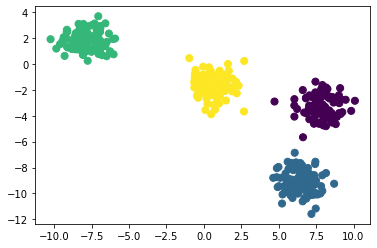

In [101]:
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
X,y = make_blobs(n_samples = 400,centers = 4,cluster_std = 0.85,random_state = 6)
plt.scatter(X[:,0],X[:,1],s=50,c=y)

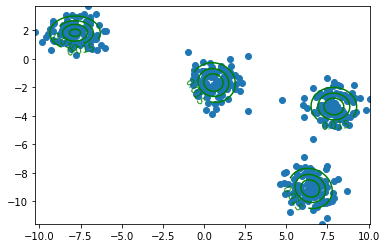

In [102]:
theta=[]
for i in range(0,4):
    data = X[y==i]
    N = data.shape[0]
    miu = np.mean(data,axis=0)
    sigma = (data - miu).T @ (data - miu) / (N - 1)
    theta.append((miu,sigma))
utils.plot_contourf(X,lambda x:np.sum([0.25*utils.gaussian_nd(x,u,sigma) for u,sigma in theta],axis=0),lines=5)

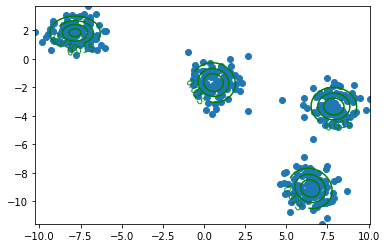

In [103]:
gmm = GMMCluster(n_compoents=4,verbose=False,n_iter=300)
gmm.fit(X)
utils.plot_contourf(X,gmm.predict_sample_generate_proba,lines=5)

In [104]:
utils.plot_decision_function(X,gmm.predict(X),gmm)